## Read and plot regional averages for the Barents Sea region

In [3]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline

### Set Bucket details

In [4]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

### open CMIP6 online catalog and read the areacello data for NorESM2-LM

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [6]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
areacello = ds_dict[list(ds_dict.keys())[0]]

#### Remove excess dimensions (i.e. member_id in this case)

In [8]:
areacello = areacello.squeeze()
areacello

<xarray.Dataset>
Dimensions:             (j: 385, i: 360, vertices: 4)
Coordinates:
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    member_id           <U8 'r1i1p1f1'
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(385, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             branch-restart from year 1600-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      430335.0
    branch_time_in_parent:     430335.0
    ...                        ...
    tracking_id:               hdl:21.14100/9996266f-aa0a-4de1-99ab-a9d732773b15
    variable_id:               areacello
    variant_label:             r1i1p1f1
    version_id:                v20210118
    intake_esm_varname:        ['areacello']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.piControl.Ofx.gn

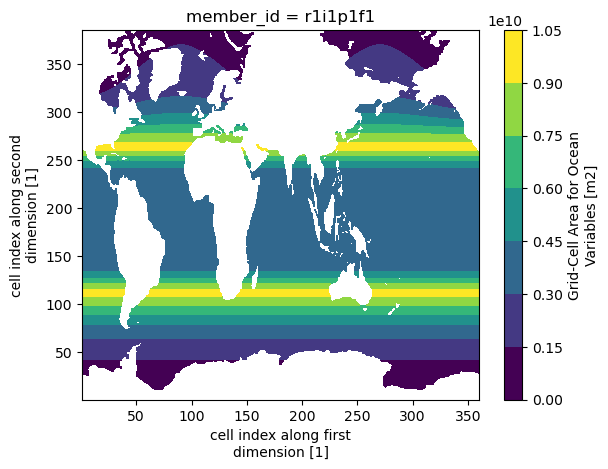

In [9]:
areacello.areacello.plot.contourf()

### The ocean grid is a bit strange in the Arctic

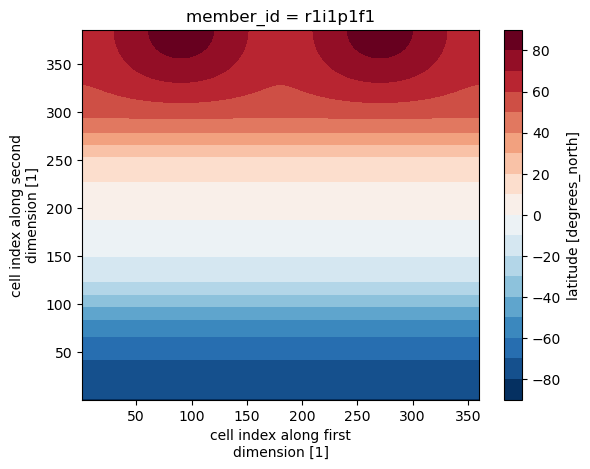

In [10]:
areacello.latitude.plot.contourf(levels = np.arange(-90,100,10))

### Select only the Northern Hemisphere (letting the Southern Hemisphere be Nans)

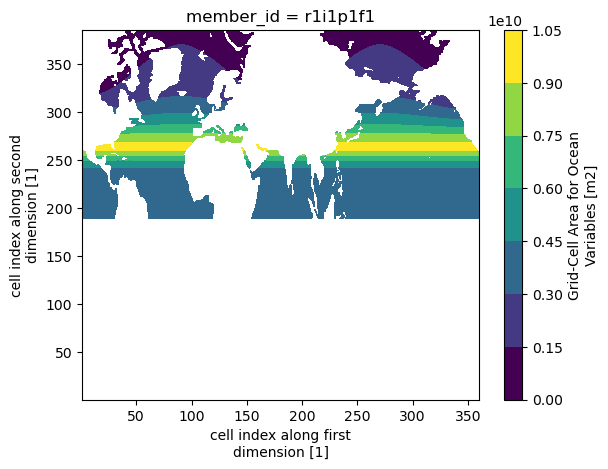

In [11]:
NHarea = areacello.areacello.where(areacello.latitude>0)
NHarea.plot.contourf()

### select only the Barents Sea 

   - Min. Lat	65° 52' 58" N (65.8828°)  
   - Min. Long	16° 34' 54.4" E (16.5818°)  
   - Max. Lat	81° 51' 4.4" N (81.8512°)  
   - Max. Long	68° 34' 41.7" E (68.5783°) 
    

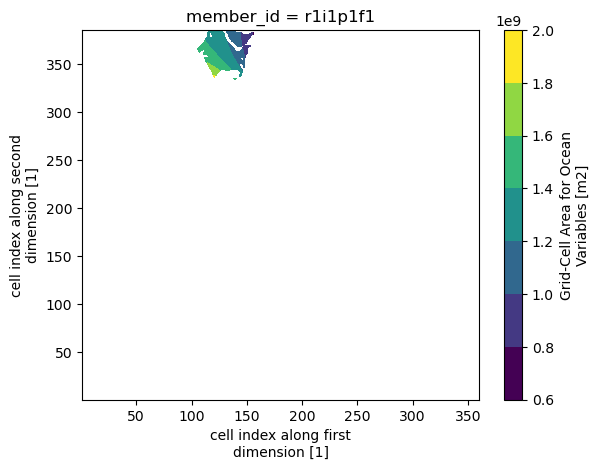

In [12]:
BSarea = areacello.areacello.where((areacello.latitude>=65.9) & (areacello.latitude<=81.9) & (areacello.longitude <= 68.6)  & (areacello.longitude >= 16.6))
BSarea.plot.contourf()

## Lets read some sea surface data from the bucket and see how it looks
### The omip1 experiment contains 6 forcing cycles over 62 years, so we only read the last 62 years  

In [21]:
remote_files = 's3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_19*.nc'
remote_files = s3.glob(remote_files)
r=remote_files[:1]
r

['escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_190001-190912.nc']

In [27]:
# Iterate through remote_files to create a fileset
#fileset = [s3.open(file) for file in remote_files]
fileset = [s3.open(file) for file in r]
ds = xr.open_mfdataset(fileset, combine='by_coords')
ds



<xarray.Dataset>
Dimensions:             (time: 120, bnds: 2, j: 385, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 1900-01-16 12:00:00 ... 1909-12-16 12:0...
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(385, 360, 4), meta=np.ndarray>
    chlos               (time, j, i) float32 dask.array<chunksize=(120, 385, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               chlos
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/669e533d-b3b1-4809-8f7d-5123814554e9

In [15]:
month_length = ds.time.dt.days_in_month
weights = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
# Test that the sum of the weights for each year is 1.0
#np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones(len(np.unique(ds.time.dt.year))))
# Calculate the weighted average:
da = (ds.get('chlos') * weights).groupby("time.year").sum(dim="time")
#da
#da.to_dataframe(name='tos')#.reset_index()

### Here we see that da contains data for 72 years, but we only need the last 62 years, so let's remove the first 10 years

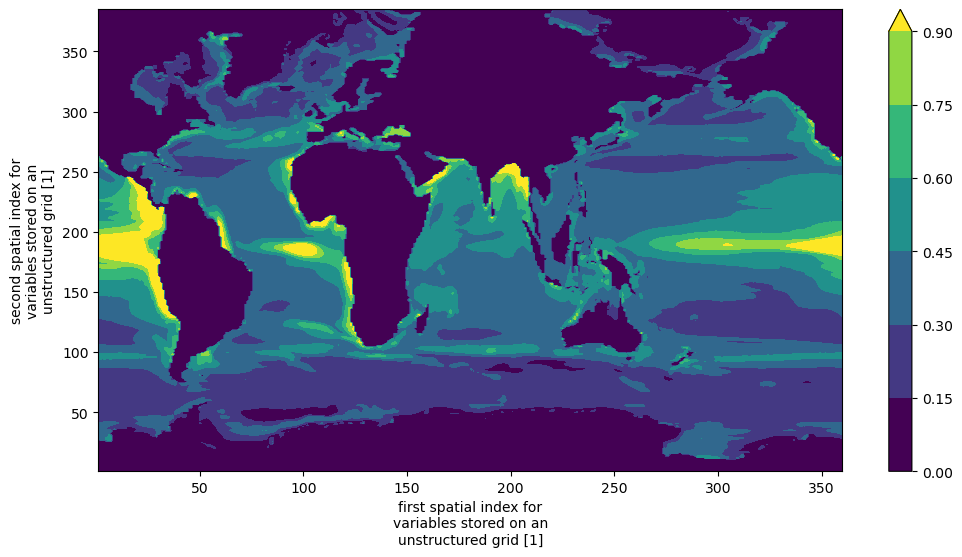

In [64]:
#da = da.isel(year = slice(10,None))
da=da#*10**6
da
#av=da.mean('year')
plt.figure(figsize=(12,6))
av.plot.contourf(cmap='viridis',robust=True)
#av

import cartopy.feature as cfeature
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo(),frameon=True)#NearsidePerspective())
ax.set_extent([0, 360, 40, 90], crs=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
crs=ccrs.PlateCarree()
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=1, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 
               "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
av.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=200)

### Let's start with the global mean SST 
#### You need to use the area of the grid cells as weights

In [65]:
da_globalmean= (areacello.areacello*da).sum(dim=('i','j'))/areacello.areacello.sum(dim=('i','j'))

In [66]:
#da_globalmean.to_dataframe(name='tos').reset_index()

In [67]:
da_globalmean

<xarray.DataArray (year: 90)>
dask.array<truediv, shape=(90,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 1910 1911 1912 1913 1914 ... 1996 1997 1998 1999

In [68]:
#da_globalmean.plot(x='year')


### Then we continue with the Barents Sea

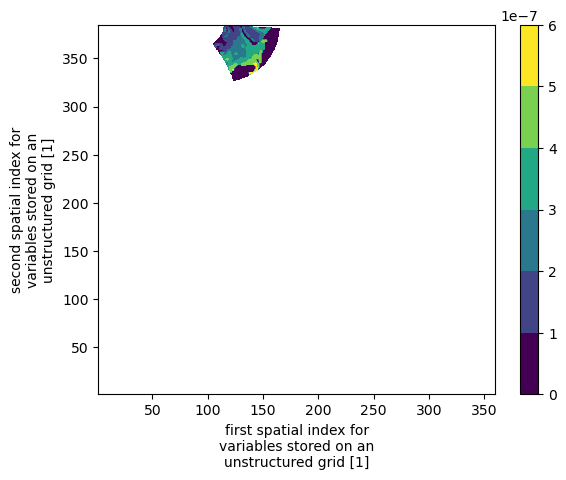

In [69]:
BSsst = da.where((da.latitude>=65.9) & (da.latitude<=81.9) & (da.longitude <= 68.6)  & (da.longitude >= 16.6))
BSsst.mean(dim='year').plot.contourf()

In [70]:
BSsst = (BSarea*10*BSsst).sum(dim=('i','j'))/(BSarea*10).sum(dim=('i','j'))
print(BSsst*10)

<xarray.DataArray (year: 90)>
dask.array<mul, shape=(90,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 1910 1911 1912 1913 1914 ... 1996 1997 1998 1999


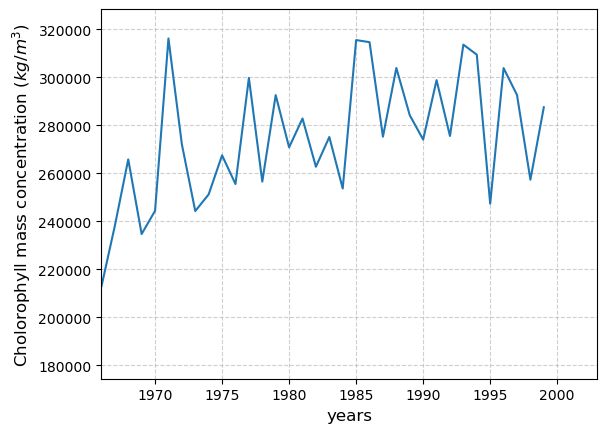

In [73]:

#a=BSsst.polyfit(dim='year',deg=1)
#print(a.to_dataframe())
BSsst=BSsst*10**(6)
BSsst.plot(x='year')

plt.xlim(1966,2003)
plt.title('')
plt.grid('True',alpha=0.6,linestyle='--')
plt.xlabel('years',fontsize=12)
plt.ylabel('Cholorophyll mass concentration ($kg/m^3$)',fontsize=12)
plt.savefig('chlorophyll_timeseries.png',dpi=500)